**Date**: 2019-05-28

**Authors**: Adam Stafford

**Purpose**: To test whether only using one species raises the accuracy.

**Background**:

From previous experiments we realized that our results of over 90% classification accuracy were due to homologous regions of DNA being present in the training and validation sets. Once this error was fixed, our accuracy dropped to under 60%. Since all of the papers that we studied only considered one species, we would like to know if we could get higher accuracy if we only considered one species.

**Experiment**:

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Load the `pickle` buffered list:

In [2]:
with open("../../data/larger_dataset/larger_dataset_buffer.txt", "rb") as buff:
    seq_record_list = pickle.load(buff)

Creating the training and test sets.

In [3]:
#from random import shuffle
#shuffle(seq_record_list)

#seq_record_list = seq_record_list[:4800]

In [4]:
validation2 = seq_record_list[(len(seq_record_list)//24-200)*24:]
training2 = seq_record_list[0:(len(seq_record_list)//24-200)*24]
print(len(training2))
training = [training2[i] for i in range(0, 31176, 24)]
print(len(validation2))
validation = [validation2[i] for i in range(0, 4800, 24)]
from random import shuffle
shuffle(validation)
shuffle(training)

31176
4800


The following cell transforms the data into a format that is recognizable by the neural network model.

In [5]:
# A helper function to flatten a 2d list to 1d.
# Input: [[1, 2], [2, 3], [3, 4, 5]]
# Output: [1, 2, 2, 3, 3, 4, 5]
def flatten(lst):
    new_lst = []
    for sub_lst in lst:
        for item in sub_lst:
            new_lst.append(item)
    return new_lst

# A helper function to transform a lst so that its length becomes read_len by:
# 1. If len(lst) > read_len, curtail the end of the lst.
# 2. If len(lst) < read_len, keep extending the end of the lst with 0 (NA).
def curtail(lst, read_len):
    if len(lst) > read_len:
        lst = lst[:read_len]
    else:
        for i in range(read_len - len(lst)):
            lst.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0])
    return lst

# Produce the train-test split
# length_read: the length that you want all DNA sequences to conform to
def prepare_input(training, test, length_read):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    seq_count = 0
    while seq_count < len(training):
        X_train.append(flatten(curtail(training[seq_count][3], length_read)))
        y_train.append(int(training[seq_count][1]))
        seq_count += 1
    seq_count = 0
    while seq_count < len(test):
        X_test.append(flatten(curtail(test[seq_count][3], length_read)))
        y_test.append(int(test[seq_count][1]))
        seq_count += 1
    return X_train, y_train, X_test, y_test

# Turn list into numpy tensors that can directly feed into a neural network model
def to_np_array(X_train, y_train, X_test, y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    if len(y_train.shape) == 1:
        y_train = np.transpose(np.array([y_train]))
    X_test = np.array(X_test)
    y_test = np.transpose(np.array(y_test))
    if len(y_test.shape) == 1:
        y_test = np.transpose(np.array([y_test]))
    return X_train, y_train, X_test, y_test

In [6]:
X_train, y_train, X_test, y_test = prepare_input(training, validation, 1000)
X_train, y_train, X_test, y_test = to_np_array(X_train, y_train, X_test, y_test)
[X_train.shape, y_train.shape, X_test.shape, y_test.shape]


[(1299, 12000), (1299, 1), (200, 12000), (200, 1)]

In [7]:
# (X_train[0])[:10]

The following cells build a recurrent network with one bidirectional LSTM layer.

In [8]:
from keras.models import Model, Sequential
from keras.layers import Dense, CuDNNLSTM, Bidirectional

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
X_train_rnn = X_train.reshape(1299, 1000, 12)
X_test_rnn = X_test.reshape(200, 1000, 12)

In [11]:
model = Sequential()
#model.add(CuDNNLSTM(8, input_shape=(1000, 8), return_sequences=True))
model.add(Bidirectional(CuDNNLSTM(16), input_shape=(1000, 12)))
#model.add(CuDNNLSTM(8, return_sequences=True))
#model.add(CuDNNLSTM(4, return_sequences=True))
#model.add(CuDNNLSTM(4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_rnn, y_train, epochs=150, batch_size=128, validation_data=(X_test_rnn, y_test))

Train on 1299 samples, validate on 200 samples
Epoch 1/150
1299/1299 [==============================] - 88s 68ms/step - loss: 0.7089 - acc: 0.4973 - val_loss: 0.7048 - val_acc: 0.4850
Epoch 2/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.6946 - acc: 0.5296 - val_loss: 0.6793 - val_acc: 0.6150
Epoch 3/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.6898 - acc: 0.5481 - val_loss: 0.6752 - val_acc: 0.6000
Epoch 4/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.6815 - acc: 0.5597 - val_loss: 0.6751 - val_acc: 0.5900
Epoch 5/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.6775 - acc: 0.5589 - val_loss: 0.6887 - val_acc: 0.5250
Epoch 6/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.6728 - acc: 0.5643 - val_loss: 0.6725 - val_acc: 0.5500
Epoch 7/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.6698 - acc: 0.5704 - val_loss: 0.6775 - val_acc: 0.5250
Epoch 

Epoch 61/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.5847 - acc: 0.6913 - val_loss: 0.6757 - val_acc: 0.5650
Epoch 62/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.5825 - acc: 0.6882 - val_loss: 0.7148 - val_acc: 0.5650
Epoch 63/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.5847 - acc: 0.7105 - val_loss: 0.6956 - val_acc: 0.5750
Epoch 64/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.5793 - acc: 0.7059 - val_loss: 0.6656 - val_acc: 0.6100
Epoch 65/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.5814 - acc: 0.7036 - val_loss: 0.6816 - val_acc: 0.5750
Epoch 66/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.5791 - acc: 0.6936 - val_loss: 0.7113 - val_acc: 0.5800
Epoch 67/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.5735 - acc: 0.7090 - val_loss: 0.7718 - val_acc: 0.5350
Epoch 68/150
1299/1299 [========================

1299/1299 [==============================] - 2s 1ms/step - loss: 0.4752 - acc: 0.7898 - val_loss: 0.8124 - val_acc: 0.5850
Epoch 122/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.4780 - acc: 0.7998 - val_loss: 0.8161 - val_acc: 0.5750
Epoch 123/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.4739 - acc: 0.7929 - val_loss: 0.7656 - val_acc: 0.6100
Epoch 124/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.4771 - acc: 0.7968 - val_loss: 0.8385 - val_acc: 0.5750
Epoch 125/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.4734 - acc: 0.7860 - val_loss: 0.8354 - val_acc: 0.5650
Epoch 126/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.4682 - acc: 0.7929 - val_loss: 0.8119 - val_acc: 0.5900
Epoch 127/150
1299/1299 [==============================] - 2s 1ms/step - loss: 0.4769 - acc: 0.7775 - val_loss: 0.7284 - val_acc: 0.5900
Epoch 128/150
1299/1299 [==============================

**Result**:

The following cell **visualize** the training/validation accuracies and losses over each epoch.

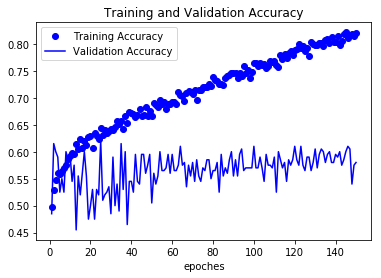

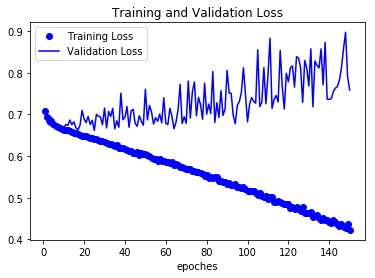

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoches')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoches')
plt.legend()

plt.show()

In [15]:
Model_weights_path = '/home/ubuntu/data/data/Models/random_PWM_2019_04_25_weights.h5'
Model_json_path = "/home/ubuntu/data/data/Models/random_PWM_2019_04_25.json"

In [16]:
model.save_weights(Model_weights_path)
model_json = model.to_json()

file = open(Model_json_path, "w")
file.write(model_json)
file.close() 

OSError: Unable to create file (unable to open file: name = '/home/ubuntu/data/data/Models/random_PWM_2019_04_25_weights.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

- The validation trend is not close to the training trend.

**Conclusion**:

- The result of the experiment shows the model performs poorly when training on random data, which is what we wanted. The model does seem to be learning something. 


### False Discovery Rate

In [26]:
from keras.models import model_from_json

with open(Model_json_path, 'r') as f:
    model = model_from_json(f.read())

model.load_weights(Model_weights_path)


In [28]:
X_test_rnn = X_test.reshape(480, 1000, 8)
results = model.predict(X_test_rnn, batch_size=16)

false_positives = 0
true_positives = 0
total_negatives = 0
total_positives = 0
true_negatives = 0

for i in range(0,results.size):
    
    if results[i][0]>=0.5 and y_test[i]==0:
        false_positives += 1

    if results[i][0]>=0.5 and y_test[i]==1:
        true_positives += 1
        
    if results[i][0]<=0.5 and y_test[i]==0:
        true_negatives += 1
        
    if results[i][0] <= 0.5:
        total_negatives += 1
        
    if results[i][0] >= 0.5:
        total_positives += 1

false_discovery_rate = false_positives/(false_positives + true_positives)
print("The false discovery rate is: {}".format(false_discovery_rate))

The false discovery rate is: 0.5251396648044693


ROC Curve


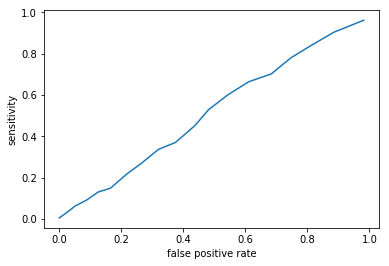

c-statistic = 0.49920460972850683


In [30]:
sensitivities = []
false_positive_rates =[]
discovery_percentage = 0.05

while discovery_percentage < 1.0:
    
    false_positives = 0
    true_positives = 0
    total_negatives = 0
    total_positives = 0
    true_negatives = 0
    
    for i in range(0,results.size):

        if results[i][0]>=discovery_percentage and y_train[i]==0:
            false_positives += 1

        if results[i][0]>=discovery_percentage and y_train[i]==1:
            true_positives += 1

        if results[i][0]<=discovery_percentage and y_train[i]==0:
            true_negatives += 1

        if y_train[i]==0:
            total_negatives += 1

        if y_train[i]==1:
            total_positives += 1
            
    if total_positives != 0 and total_negatives != 0:
        sensitivities.append(true_positives / total_positives)
        false_positive_rates.append(1-(true_negatives / total_negatives))
    
    discovery_percentage += 0.05
    
riemann = 0.0
for i in range(0,len(sensitivities) - 1):
    riemann += 0.5 * (sensitivities[i]+sensitivities[i+1]) * (false_positive_rates[i]-false_positive_rates[i+1])
    

print("ROC Curve")
plt.plot(false_positive_rates, sensitivities )
plt.ylabel('sensitivity')
plt.xlabel('false positive rate')
plt.show()
print("c-statistic = " + str(riemann))


This model is no better than predicting and outcome than random chance so the model does seem to be learning something. 